In [1]:
import json
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import Masking
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import numpy as np
features_d1 = []
labels_d1 = []
labels_domain = []
# Open file for reading
with open('domain1_train.json', 'r') as f:
    for line in f:
        # Parse the JSON line into a Python dictionary
        obj = json.loads(line)
        features_d1.append(obj['text'])
        labels_d1.append(obj['label'])

        if obj['label']  == 0 :
            labels_domain.append(7)
        else:
            labels_domain.append(8)

features_d2 = []
labels_d2 = []
# Open file for reading
with open('domain2_train.json', 'r') as f:
    for line in f:
        # Parse the JSON line into a Python dictionary
        obj = json.loads(line)
        features_d2.append(obj['text'])
        labels_d2.append(obj['label'])
        if obj['label'] == 0:
            labels_domain.append(int(obj['model']))
        else:
            labels_domain.append(8)


In [2]:
features = features_d1 + features_d2
labels = labels_d1 + labels_d2
new_features = []
for text in features:
    new_text = [x + 1 for x in text]
    new_features.append(new_text)

In [3]:
# Split the data
padded_features = pad_sequences(new_features, padding='pre', value=0)
labels_domain = to_categorical(labels_domain, num_classes=9)

labels = to_categorical(labels, num_classes=2)
X_train, X_test, y_label_train, y_label_test, y_domain_train, y_domain_test = train_test_split(
    padded_features, labels, labels_domain, test_size=0.2, random_state=42
)
y_train = {'label': y_label_train, 'domain': y_domain_train}
y_test = {'label': y_label_test, 'domain': y_domain_test}

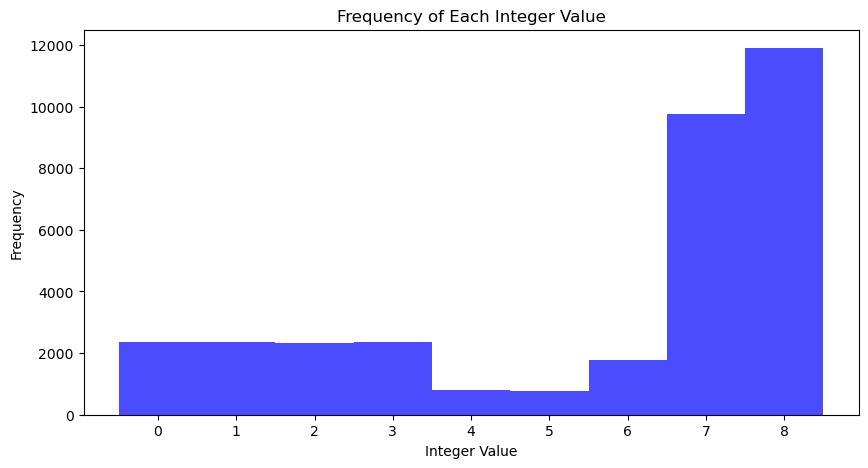

In [131]:
import matplotlib.pyplot as plt



# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(labels_domain, bins=range(min(labels_domain), max(labels_domain) + 2), align='left', alpha=0.7, color='blue')

# Label axes
plt.xlabel('Integer Value')
plt.ylabel('Frequency')

# Add title
plt.title('Frequency of Each Integer Value')

# Add integer labels to x-axis
plt.xticks(range(min(labels_domain), max(labels_domain) + 1))

# Show plot
plt.show()

In [138]:
padded_features = pad_sequences(new_features, padding='pre', value=0)
labels = to_categorical(labels, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(padded_features, labels, test_size=0.2, random_state=42)

In [150]:
class_weights = np.sum(y_train["domain"], axis=0) / len(y_train["domain"])

In [151]:
class_weights

array([0.06965843, 0.06882267, 0.06773256, 0.06849564, 0.02303779,
       0.02274709, 0.05221657, 0.28175873, 0.3455305 ], dtype=float32)

In [1]:
from keras.models import Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dense, Dropout, Masking, Input, Bidirectional, concatenate
from keras.regularizers import l2
from keras.layers import Flatten
import tensorflow as tf
class_weights = np.sum(y_train["domain"], axis=0) / len(y_train)
class_weights = 1 / class_weights
normalized_weights = class_weights / np.sum(class_weights)


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 with 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss, ...)
    """
    
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        # scale predictions so that the class probabilities of each sample sum to 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        
        # clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        
        # compute weighted loss
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, axis=-1)
        return loss
    
    return loss






# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_classes = 2  # Binary classification for the main task
n_domain_classes = 9  # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)


dropout_lstm_1 = Dropout(0.5)(embedding_layer)
# LSTM Layer
lstm_layer = Bidirectional(LSTM(32))(embedding_layer)
dropout_lstm_2 = Dropout(0.5)(lstm_layer)

lstm_output = Flatten()(dropout_lstm_2)

# Conv1D Layer
conv1d_layer_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
# Conv1D Layer
conv1d_layer_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1d_layer_1)


global_max_pooling = GlobalMaxPooling1D()(conv1d_layer_2)

#Dense
cnn_output= Dense(32)(global_max_pooling)

# Concatenate Layer
concat_layer = concatenate([cnn_output, lstm_output])

#Dense
dense_layer = Dense(32, activation='relu')(concat_layer)



# Task output
task_output = Dense(n_classes, activation='sigmoid', name='label')(dense_layer)

# Domain output
domain_output = Dense(n_domain_classes, activation='softmax', name='domain')(dense_layer)

# Combined model
model = Model(inputs=input_layer, outputs=[task_output, domain_output])



model.compile(optimizer='adam',
              loss={
                  'label': 'binary_crossentropy',
                  'domain': weighted_categorical_crossentropy(normalized_weights)
              },
              metrics=['accuracy'])


# Model summary
model.summary()

NameError: name 'np' is not defined

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='domain_loss', patience=2, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 128)

Epoch 1/50
 12/215 [>.............................] - ETA: 10:19 - loss: 0.7820 - label_loss: 0.6638 - domain_loss: 0.1183 - label_accuracy: 0.6074 - domain_accuracy: 0.0775

KeyboardInterrupt: 

In [12]:
vocab_size = 5000
embedding_dim = 100
n_classes = 2
n_domain_classes = 9

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)

# Masking Layer
masking_layer = Masking(mask_value=0.0)(embedding_layer)

# Conv1D Layer
conv1d_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(masking_layer)

# Dropout Layer
dropout1 = Dropout(0.5)(conv1d_layer)

# Max Pooling Layer
max_pooling1 = MaxPooling1D(pool_size=2)(dropout1)

# Shared LSTM Layer
shared_lstm_layer = LSTM(32)(max_pooling1)

# Dropout Layer (Shared)
shared_dropout = Dropout(0.5)(shared_lstm_layer)

# Binary Classification Specific Layers
dense_binary = Dense(32, activation='relu')(shared_dropout)
dropout_binary = Dropout(0.5)(dense_binary)
output_binary = Dense(n_classes, activation='sigmoid', name='label')(dropout_binary)

# Multi-class Classification Specific Layers
dense_multi = Dense(32, activation='relu')(shared_dropout)
dropout_multi = Dropout(0.5)(dense_multi)
output_multi = Dense(n_domain_classes, activation='softmax', name='domain')(dropout_multi)

# Combined model
model = Model(inputs=input_layer, outputs=[output_binary, output_multi])

# Compile the model
model.compile(optimizer='adam', 
              loss={'label': 'binary_crossentropy', 'domain':  weighted_categorical_crossentropy(normalized_weights)}, 
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 100)    500000      ['input_6[0][0]']                
                                                                                                  
 masking_5 (Masking)            (None, None, 100)    0           ['embedding_5[0][0]']            
                                                                                                  
 conv1d_5 (Conv1D)              (None, None, 32)     9632        ['masking_5[0][0]']              
                                                                                            

In [2]:
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_classes = 2  # Binary classification for the main task
n_domain_classes = 2  # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)

# Masking Layer
masking_layer = Masking(mask_value=0.0)(embedding_layer)


# LSTM Layer
lstm_layer_1 = LSTM(128, return_sequences=True)(masking_layer)

# Dropout Layer
dropout1 = Dropout(0.4)(lstm_layer_1)

##LSTM Layer
lstm_layer_2 = LSTM(64)(dropout1)

# Dropout Layer
dropout2 = Dropout(0.4)(lstm_layer_2)

dense = Dense(32, activation='relu')(dropout2)

# Task output
task_output = Dense(n_classes, activation='sigmoid', name='label')(dense)

# Domain output
domain_output = Dense(n_domain_classes, activation='sigmoid', name='domain')(dense)

# Combined model
model = Model(inputs=input_layer, outputs=[task_output, domain_output])



model.compile(optimizer='adam',
              loss={
                  'label': 'binary_crossentropy',
                  'domain': 'binary_crossentropy'
              },
              metrics=['accuracy'])


# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    500000      ['input_1[0][0]']                
                                                                                                  
 masking (Masking)              (None, None, 100)    0           ['embedding[0][0]']              
                                                                                                  
 lstm (LSTM)                    (None, None, 128)    117248      ['masking[0][0]']                
                                                                                              

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='domain_loss', patience=2, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 128)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\chenj\anaconda3\envs\CV\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((128, 533, 2) vs (128, 2)).


In [19]:

vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_classes = 2  # Binary classification for the main task
n_domain_classes = 9  # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)

# Masking Layer
masking_layer = Masking(mask_value=0.0)(embedding_layer)


# LSTM Layer
lstm_layer_1 = LSTM(32, return_sequences=True)(masking_layer)

# Dropout Layer
dropout1 = Dropout(0.2)(lstm_layer_1)

##LSTM Layer
lstm_layer_2 = LSTM(16)(dropout1)

# Task output
task_output = Dense(n_classes, activation='sigmoid', name='label')(lstm_layer_2)

# Domain output
domain_output = Dense(n_domain_classes, activation='softmax', name='domain')(lstm_layer_2)

# Combined model
model = Model(inputs=input_layer, outputs=[task_output, domain_output])



model.compile(optimizer='adam',
              loss={
                  'label': 'binary_crossentropy',
                  'domain': weighted_categorical_crossentropy(normalized_weights)
              },
              metrics=['accuracy'])


# Model summary
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, None, 100)    500000      ['input_9[0][0]']                
                                                                                                  
 masking_8 (Masking)            (None, None, 100)    0           ['embedding_8[0][0]']            
                                                                                                  
 lstm_10 (LSTM)                 (None, None, 32)     17024       ['masking_8[0][0]']              
                                                                                            

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='domain_loss', patience=2, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 128)

Epoch 1/50
215/215 [==============================] - 127s 569ms/step - loss: 0.5943 - label_loss: 0.4818 - domain_loss: 0.1125 - label_accuracy: 0.7919 - domain_accuracy: 0.2258 - val_loss: 0.7425 - val_label_loss: 0.6290 - val_domain_loss: 0.1135 - val_label_accuracy: 0.6525 - val_domain_accuracy: 0.0235
Epoch 2/50
 91/215 [===========>..................] - ETA: 1:14 - loss: 0.6354 - label_loss: 0.5212 - domain_loss: 0.1142 - label_accuracy: 0.7497 - domain_accuracy: 0.1588

KeyboardInterrupt: 

In [112]:
y_train["domain"]

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [113]:
y_train["label"]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [119]:
from keras.models import Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dense, Dropout, Masking, Input, Bidirectional
from keras.regularizers import l2
import tensorflow as tf
import sys
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        weighted_losses = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(weighted_losses, axis=-1)

        
        return loss

    return loss
# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_classes = 2  # Binary classification for the main task
n_domain_classes = 9  # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)

# Masking Layer
masking_layer = Masking(mask_value=0.0)(embedding_layer)

# LSTM Layer
bilstm_layer = Bidirectional(LSTM(32, return_sequences=True))(masking_layer)

# Dropout Layer
dropout2 = Dropout(0.5)(bilstm_layer)

# GlobalMaxPooling Layer
global_max_pooling = GlobalMaxPooling1D()(dropout2)
# New Dense Layer
dense_layer = Dense(32, activation='relu')(global_max_pooling)
dense_dropout = Dropout(0.5)(dense_layer)

# Task output
task_output = Dense(n_classes, activation='sigmoid', name='label')(dense_dropout)

# Domain output
domain_output = Dense(n_domain_classes, activation='softmax', name='domain')(dense_dropout)

# Combined model
bilstm_model = Model(inputs=input_layer, outputs=[task_output, domain_output])



weights_for_domain = [0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.04]  

bilstm_model.compile(optimizer='adam',
              loss={
                  'label': 'binary_crossentropy',
                  'domain': weighted_categorical_crossentropy(weights_for_domain)
              },
              metrics=['accuracy'])



# Model summary
model.summary()


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, None, 100)    500000      ['input_21[0][0]']               
                                                                                                  
 masking_20 (Masking)           (None, None, 100)    0           ['embedding_20[0][0]']           
                                                                                                  
 bidirectional_20 (Bidirectiona  (None, None, 64)    34048       ['masking_20[0][0]']             
 l)                                                                                        

In [120]:
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 64)

Epoch 1/50
430/430 [==============================] - 201s 457ms/step - loss: 0.5185 - label_loss: 0.3670 - domain_loss: 0.1514 - label_accuracy: 0.8638 - domain_accuracy: 0.4871 - val_loss: 0.4659 - val_label_loss: 0.3393 - val_domain_loss: 0.1266 - val_label_accuracy: 0.9042 - val_domain_accuracy: 0.5705
Epoch 2/50
430/430 [==============================] - 200s 465ms/step - loss: 0.3788 - label_loss: 0.2600 - domain_loss: 0.1187 - label_accuracy: 0.9115 - domain_accuracy: 0.5745 - val_loss: 0.4290 - val_label_loss: 0.3130 - val_domain_loss: 0.1161 - val_label_accuracy: 0.9092 - val_domain_accuracy: 0.5983
Epoch 3/50
430/430 [==============================] - 169s 394ms/step - loss: 0.3290 - label_loss: 0.2194 - domain_loss: 0.1096 - label_accuracy: 0.9214 - domain_accuracy: 0.6072 - val_loss: 0.3977 - val_label_loss: 0.2892 - val_domain_loss: 0.1086 - val_label_accuracy: 0.9077 - val_domain_accuracy: 0.6243
Epoch 4/50
430/430 [==============================] - 152s 346ms/step - loss

KeyboardInterrupt: 

In [138]:
from keras.models import Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dense, Dropout, Masking, Input, Bidirectional
from keras.regularizers import l2
import tensorflow as tf
import sys
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        weighted_losses = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(weighted_losses, axis=-1)

        
        return loss

    return loss
# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 156 # Embedding dimension
n_classes = 2  # Binary classification for the main task
n_domain_classes = 9  # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)

# Masking Layer
masking_layer = Masking(mask_value=0.0)(embedding_layer)

# LSTM Layer
lstm_layer = LSTM(32)(masking_layer)

# Dropout Layer
dropout_lstm = Dropout(0.5)(lstm_layer)


# New Dense Layer
dense_layer = Dense(16, activation='relu')(dropout_lstm)
dense_dropout = Dropout(0.3)(dense_layer)

# Task output
task_output = Dense(n_classes, activation='sigmoid', name='label')(dense_dropout)

# Domain output
domain_output = Dense(n_domain_classes, activation='softmax', name='domain')(dense_dropout)

# Combined model
lstm_model = Model(inputs=input_layer, outputs=[task_output, domain_output])



weights_for_domain = [0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.05, 0.04]  

lstm_model.compile(optimizer='adam',
              loss={
                  'label': 'binary_crossentropy',
                  'domain': weighted_categorical_crossentropy(weights_for_domain)
              },
              metrics=['accuracy'])



# Model summary
lstm_model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_30 (Embedding)       (None, None, 156)    780000      ['input_31[0][0]']               
                                                                                                  
 masking_30 (Masking)           (None, None, 156)    0           ['embedding_30[0][0]']           
                                                                                                  
 lstm_30 (LSTM)                 (None, 32)           24192       ['masking_30[0][0]']             
                                                                                           

In [139]:
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 64)

Epoch 1/50
430/430 [==============================] - 85s 191ms/step - loss: 0.5403 - label_loss: 0.3889 - domain_loss: 0.1514 - label_accuracy: 0.8555 - domain_accuracy: 0.3940 - val_loss: 0.4044 - val_label_loss: 0.2772 - val_domain_loss: 0.1272 - val_label_accuracy: 0.8994 - val_domain_accuracy: 0.5506
Epoch 2/50
430/430 [==============================] - 80s 187ms/step - loss: 0.3921 - label_loss: 0.2630 - domain_loss: 0.1291 - label_accuracy: 0.9107 - domain_accuracy: 0.5351 - val_loss: 0.3842 - val_label_loss: 0.2645 - val_domain_loss: 0.1197 - val_label_accuracy: 0.9031 - val_domain_accuracy: 0.5674
Epoch 3/50
430/430 [==============================] - 78s 182ms/step - loss: 0.3328 - label_loss: 0.2094 - domain_loss: 0.1234 - label_accuracy: 0.9241 - domain_accuracy: 0.5612 - val_loss: 0.3862 - val_label_loss: 0.2678 - val_domain_loss: 0.1184 - val_label_accuracy: 0.9067 - val_domain_accuracy: 0.5844
Epoch 4/50
430/430 [==============================] - 79s 184ms/step - loss: 0.

In [97]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from keras.regularizers import l2

# Constants
vocab_size = 5000  # Same as your BiLSTM model
embedding_dim = 100  # Same as your BiLSTM model
sequence_length = 300  # Same as your BiLSTM model
n_classes = 2  # Binary classification



# Model architecture
cnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    Masking(mask_value=0),  # Masking layer
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=5),
    Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=3),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(n_classes, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 300, 100)          500000    
                                                                 
 masking_22 (Masking)        (None, 300, 100)          0         
                                                                 
 conv1d_71 (Conv1D)          (None, 298, 64)           19264     
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 59, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_72 (Conv1D)          (None, 55, 64)            20544     
                                                                 
 max_pooling1d_55 (MaxPoolin  (None, 18, 64)           0         
 g1D)                                                

In [153]:
bilstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 64)

Epoch 1/50
430/430 [==============================] - 77s 173ms/step - loss: 0.4341 - accuracy: 0.8629 - val_loss: 0.3145 - val_accuracy: 0.9016
Epoch 2/50
430/430 [==============================] - 71s 165ms/step - loss: 0.3054 - accuracy: 0.9056 - val_loss: 0.2990 - val_accuracy: 0.9029
Epoch 3/50
430/430 [==============================] - 69s 160ms/step - loss: 0.2722 - accuracy: 0.9160 - val_loss: 0.2898 - val_accuracy: 0.9045
Epoch 4/50
430/430 [==============================] - 69s 160ms/step - loss: 0.2461 - accuracy: 0.9215 - val_loss: 0.2919 - val_accuracy: 0.9068
Epoch 5/50
430/430 [==============================] - 69s 161ms/step - loss: 0.2323 - accuracy: 0.9250 - val_loss: 0.3003 - val_accuracy: 0.9058
Epoch 6/50
430/430 [==============================] - 69s 160ms/step - loss: 0.2175 - accuracy: 0.9270 - val_loss: 0.2916 - val_accuracy: 0.9025
Epoch 7/50
430/430 [==============================] - 69s 160ms/step - loss: 0.2079 - accuracy: 0.9270 - val_loss: 0.2965 - val_ac

In [205]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
cnn_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=[early_stopping], batch_size = 64)

Epoch 1/50
430/430 [==============================] - 55s 125ms/step - loss: 0.3389 - accuracy: 0.8675 - val_loss: 0.3334 - val_accuracy: 0.9049
Epoch 2/50
430/430 [==============================] - 53s 123ms/step - loss: 0.2437 - accuracy: 0.9131 - val_loss: 0.3110 - val_accuracy: 0.9068
Epoch 3/50
430/430 [==============================] - 54s 126ms/step - loss: 0.2114 - accuracy: 0.9196 - val_loss: 0.2972 - val_accuracy: 0.9045
Epoch 4/50
430/430 [==============================] - 54s 125ms/step - loss: 0.1872 - accuracy: 0.9251 - val_loss: 0.2802 - val_accuracy: 0.9064
Epoch 5/50
430/430 [==============================] - 54s 125ms/step - loss: 0.1673 - accuracy: 0.9305 - val_loss: 0.2743 - val_accuracy: 0.9064
Epoch 6/50
430/430 [==============================] - 54s 126ms/step - loss: 0.1481 - accuracy: 0.9375 - val_loss: 0.2682 - val_accuracy: 0.9007
Epoch 7/50
430/430 [==============================] - 54s 125ms/step - loss: 0.1283 - accuracy: 0.9473 - val_loss: 0.2607 - val_ac

In [98]:
cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping], batch_size = 64)

Epoch 1/50
344/344 [==============================] - 7s 20ms/step - loss: 0.7572 - accuracy: 0.7587 - val_loss: 0.4275 - val_accuracy: 0.8777
Epoch 2/50
344/344 [==============================] - 6s 19ms/step - loss: 0.4677 - accuracy: 0.8538 - val_loss: 0.3964 - val_accuracy: 0.8850
Epoch 3/50
344/344 [==============================] - 6s 18ms/step - loss: 0.4437 - accuracy: 0.8592 - val_loss: 0.3967 - val_accuracy: 0.8877
Epoch 4/50
344/344 [==============================] - 6s 18ms/step - loss: 0.4241 - accuracy: 0.8661 - val_loss: 0.3841 - val_accuracy: 0.8884
Epoch 5/50
344/344 [==============================] - 6s 19ms/step - loss: 0.4135 - accuracy: 0.8684 - val_loss: 0.3670 - val_accuracy: 0.8917
Epoch 6/50
344/344 [==============================] - 6s 18ms/step - loss: 0.3932 - accuracy: 0.8726 - val_loss: 0.3645 - val_accuracy: 0.8866
Epoch 7/50
344/344 [==============================] - 6s 18ms/step - loss: 0.3838 - accuracy: 0.8752 - val_loss: 0.3588 - val_accuracy: 0.8894

In [17]:
def update_feature(features):
    new_features = []
    for text in features:
        new_text = [x + 1 for x in text]
        new_features.append(new_text)
    return new_features


In [18]:
test_ids = []
test_texts = []
# Open file for reading
with open('test_set.json', 'r') as f:
    for line in f:
        # Parse the JSON line into a Python dictionary
        obj = json.loads(line)
        test_ids.append(obj['id'])
        test_texts.append(obj['text'])
test_texts = update_feature(test_texts)
test_features = pad_sequences(test_texts, padding='pre', value=0)
import numpy as np
# Make predictions
predictions = model.predict(test_features)

# Interpret predictions
final_predictions = np.argmax(predictions[0], axis=1)

print(final_predictions)

32/32 [==============================] - 5s 86ms/step
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1
 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0
 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1
 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0
 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0
 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0

In [114]:
predictions[1]

array([[2.0865549e-01, 6.1077189e-02, 2.1181773e-01, ..., 1.3245154e-03,
        1.7993655e-03, 3.0141464e-01],
       [4.3838033e-03, 3.4897596e-02, 6.6804737e-03, ..., 9.0304613e-01,
        8.4550715e-07, 1.5515679e-05],
       [2.2277078e-02, 2.8923299e-02, 2.0886326e-02, ..., 4.1087014e-03,
        6.7362559e-01, 2.2471841e-01],
       ...,
       [2.7027252e-04, 5.8505828e-03, 2.5348720e-04, ..., 6.0437560e-05,
        9.9267972e-01, 6.0676603e-04],
       [1.0504868e-05, 9.0645754e-06, 2.4993237e-06, ..., 1.7466247e-07,
        4.1348231e-03, 9.9584204e-01],
       [2.3415886e-01, 9.9158414e-02, 2.4144238e-01, ..., 1.7545497e-03,
        6.5056491e-04, 1.7444958e-01]], dtype=float32)

In [103]:
import pandas as pd
output_df = pd.DataFrame({"id":test_ids, "class": final_predictions})

In [104]:
output_df.to_csv("output.csv", index=False)

In [107]:
import numpy as np

def ensemble_predictions(models, x_test):
    # Get predictions from each model
    preds = [model.predict(x_test) for model in models]
    
    # Average the predictions
    avg_preds = np.mean(preds, axis=0)
    
    final_predictions = np.argmax(avg_preds, axis=1)

    
    return  final_predictions 

# Example usage
models = [cnn_model, bilstm_model]  # Assuming cnn_model and bilstm_model are your trained models
ensemble_preds = ensemble_predictions(models, test_features)

print(ensemble_preds)  # Output should be like [0, 1, 1, 1, ...]

output_df = pd.DataFrame({"id":test_ids, "class": ensemble_preds})
output_df.to_csv("output.csv", index=False)

32/32 [==============================] - 1s 20ms/step
[0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0
 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1
 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0

In [104]:
ensemble_preds

array([1, 0, 1, ..., 1, 1, 0])